In [56]:
import numpy as np
import torch.nn as nn
import torch
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from itertools import product

In [57]:
# Load the MB Model

class CustomModel_CF(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(5,4),
            nn.ReLU(),
            nn.Linear(4,2),
            nn.ReLU(),
            nn.Linear(2,1),
        )

    def forward(self, x):
        t = x[:,4].unsqueeze(1)
        C0 = x[:,3].unsqueeze(1)
        a0 = self.hidden(x).chunk(5, dim=1)

        k = a0[0]**2


        return C0*torch.exp(-k*t)

class CustomModel_CA(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Sequential(
            nn.Linear(5,4),
            nn.ReLU(),
            nn.Linear(4,2),
            nn.ReLU(),
            nn.Linear(2,1),
        )

    def forward(self, x):
        t = x[:,4].unsqueeze(1)
        a0= self.hidden(x).chunk(5, dim=1)

        k = a0[0]**2


        return torch.exp(k*t)-1
    
model_CF = CustomModel_CF()
model_CF.load_state_dict(torch.load('model_CF.pth'))
model_CA = CustomModel_CA()
model_CA.load_state_dict(torch.load('model_CA.pth'))

<All keys matched successfully>

In [58]:
# Load the surrogate model
with open('GPR1.pkl', 'rb') as f:
    GPR1 = pickle.load(f)

with open('GPR2.pkl', 'rb') as f:
    GPR2 = pickle.load(f)

c:\Python\Python312\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator GaussianProcessRegressor from version 1.3.2 when using version 1.5.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [59]:
# Load the Data
raw_Data= pd.read_excel('BMED_data.xlsx',sheet_name="Opt")
display(raw_Data[:5])

,T,V,E,Ci,t,CF,CA,SEC,JLA
0,35,35,0.5,3.247751,2.000000,2.666598,0.278508,6.563329,223.608106
1,35,35,0.5,3.247751,2.933333,2.470914,0.583058,5.408487,543.993190
2,35,35,0.5,3.247751,3.933333,2.193242,1.068941,3.958080,1056.942907
3,35,35,0.5,3.247751,4.933333,1.570518,1.598939,3.211235,1337.426543
4,35,35,0.5,3.247751,5.933333,0.258292,2.087098,2.788854,1432.411229


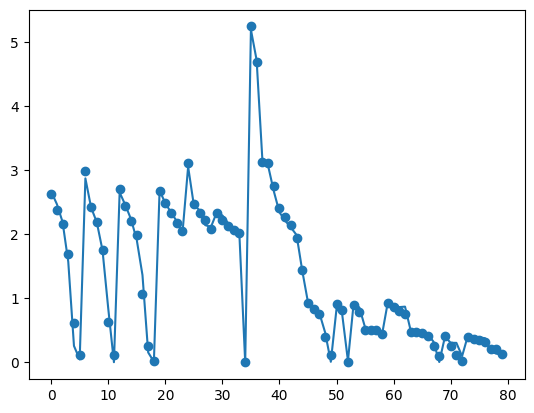

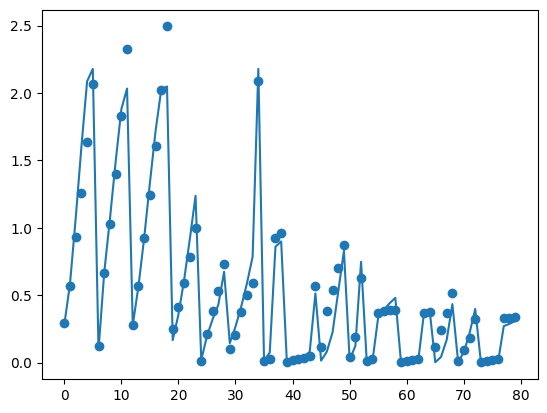

In [60]:
# MB model confirmation
df_MB_columns = ['T','V','E','Ci','t','CF','CA']
df_MB = raw_Data[df_MB_columns]

# Data Set
Xm = df_MB[['T','V','E','Ci','t']].values
Xt = torch.FloatTensor(Xm)

CF_p = model_CF(Xt).detach().numpy()
CA_p = model_CA(Xt).detach().numpy()
CF = df_MB[['CF']].values
CA = df_MB[['CA']].values

plt.plot(list(range(len(Xm))),CF)
plt.scatter(list(range(len(Xm))),CF_p)
plt.show()

plt.plot(list(range(len(Xm))),CA)
plt.scatter(list(range(len(Xm))),CA_p)
plt.show()

In [61]:
# GP model confirmation
df_GP_columns = ['T','V','E','Ci','t','SEC','JLA']
df_GP = raw_Data[df_GP_columns]

# Data Set
Xg = df_GP[['T','V','E','Ci','t']].values
Yg = df_GP[['SEC','JLA']].values

T, V, E, Ci, dt = [i[0] for i in Xg], [i[1] for i in Xg], [i[2] for i in Xg], [i[3] for i in Xg], [i[4] for i in Xg]
SEC, JLA = [i[0] for i in Yg], [i[1] for i in Yg]

# min-max normalization
mXg = list(range(len(Xg)))
mYg = list(range(len(Yg)))

for i in range(len(mXg)):
    iX = [(T[i]-np.min(T))/(np.max(T)-np.min(T)),(V[i]-np.min(V))/(np.max(V)-np.min(V)),(E[i]-np.min(E))/(np.max(E)-np.min(E)),(dt[i]-np.min(dt))/(np.max(dt)-np.min(dt)),(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci))]
    iY = [(SEC[i]-np.min(SEC))/(np.max(SEC)-np.min(SEC)),(JLA[i]-np.min(JLA))/(np.max(JLA)-np.min(JLA))]
    mXg[i], mYg[i] = iX, iY
mX, mY = np.asarray(mXg), np.log(np.asarray(mYg)+0.1)

In [62]:
dSEC_log, dJLA_log = GPR1.predict(mX), GPR2.predict(mX)

mSEC = np.exp(dSEC_log)-0.1
mJLA = np.exp(dJLA_log)-0.1

SECp = list(range(len(Xg)))
JLAp = list(range(len(Xg)))
for i in range(len(Xg)):
    iSEC = (np.max(SEC) - np.min(SEC))*mSEC[i] + np.min(SEC)
    iJLA = (np.max(JLA) - np.min(JLA))*mJLA[i] + np.min(JLA)
    SECp[i] = iSEC
    JLAp[i] = iJLA



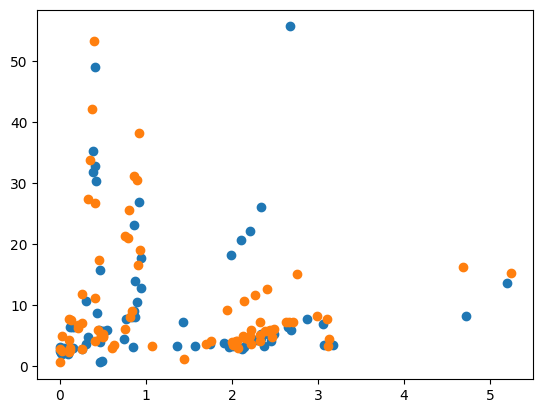

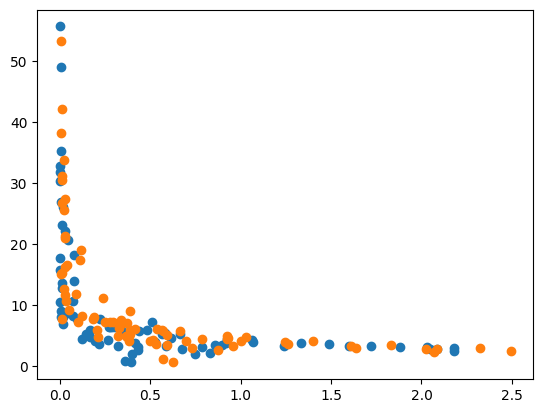

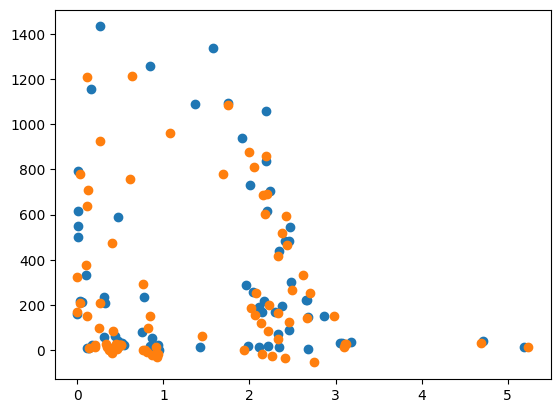

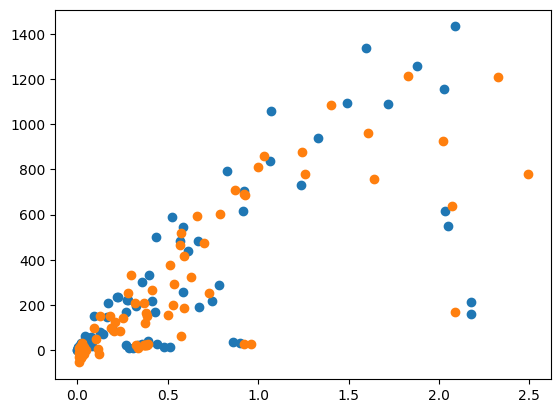

In [63]:
plt.scatter(raw_Data['CF'],raw_Data['SEC'])
plt.scatter(CF_p,SECp)
plt.show()
plt.scatter(raw_Data['CA'],raw_Data['SEC'])
plt.scatter(CA_p,SECp)
plt.show()
plt.scatter(raw_Data['CF'],raw_Data['JLA'])
plt.scatter(CF_p,JLAp)
plt.show()
plt.scatter(raw_Data['CA'],raw_Data['JLA'])
plt.scatter(CA_p,JLAp)
plt.show()

In [64]:
nT = np.unique(raw_Data['T'].values)
nV = np.unique(raw_Data['V'].values)
nE = np.unique(raw_Data['E'].values)
nt = np.unique(raw_Data['t'].values)
nC = np.unique(raw_Data['Ci'].values)
print('nC done')
input = np.array(list(product(nT,nV,nE,nT,nC)))
print('input done')
#Xm = df_MB[['T','V','E','Ci','t']].values
#input = np.array(Xm)
in_t = torch.FloatTensor(input)
print('in_t Done')
CFp = model_CF(in_t).detach().numpy()
print('CFP done')
CAp = model_CA(in_t).detach().numpy()
print('CAP done')
T, V, E, Ci, dt = [i[0] for i in input], [i[1] for i in input], [i[2] for i in input], [i[3] for i in input], [i[4] for i in input]

# min-max normalization
mXg = list(range(len(input)))

for i in range(len(mXg)):
    iX = [(T[i]-np.min(T))/(np.max(T)-np.min(T)),(V[i]-np.min(V))/(np.max(V)-np.min(V)),(E[i]-np.min(E))/(np.max(E)-np.min(E)),(dt[i]-np.min(dt))/(np.max(dt)-np.min(dt)),(Ci[i]-np.min(Ci))/(np.max(Ci)-np.min(Ci))]
    mXg[i] = iX
    if i%100 ==0:
        print(f'Iteration: {i}/{len(input)}')
    
mX = np.asarray(mXg)

nC done
input done
in_t Done
CFP done
CAP done
Iteration: 0/720
Iteration: 100/720
Iteration: 200/720
Iteration: 300/720
Iteration: 400/720
Iteration: 500/720
Iteration: 600/720
Iteration: 700/720


In [65]:
dSEC_log = GPR1.predict(mX)
dJLA_log = GPR2.predict(mX)

mSEC = np.exp(dSEC_log)-0.1
mJLA = np.exp(dJLA_log)-0.1

SECp = list(range(len(mSEC)))
JLAp = list(range(len(mSEC)))
for i in range(len(mSEC)):
    iSEC = (np.max(SEC) - np.min(SEC))*mSEC[i] + np.min(SEC)
    iJLA = (np.max(JLA) - np.min(JLA))*mJLA[i] + np.min(JLA)
    SECp[i] = iSEC
    JLAp[i] = iJLA

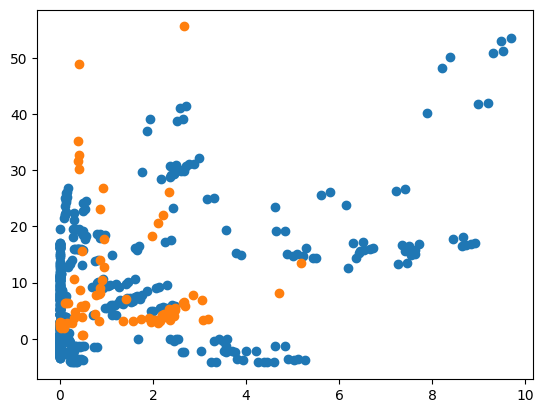

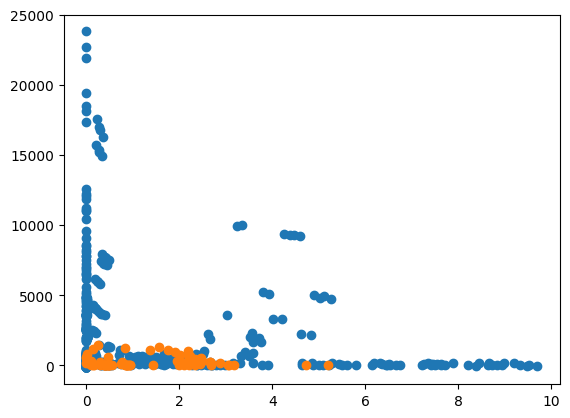

In [66]:
plt.scatter(CFp,SECp)
plt.scatter(raw_Data['CF'],raw_Data['SEC'])
plt.show()
plt.scatter(CFp,JLAp)
plt.scatter(raw_Data['CF'],raw_Data['JLA'])
plt.show()



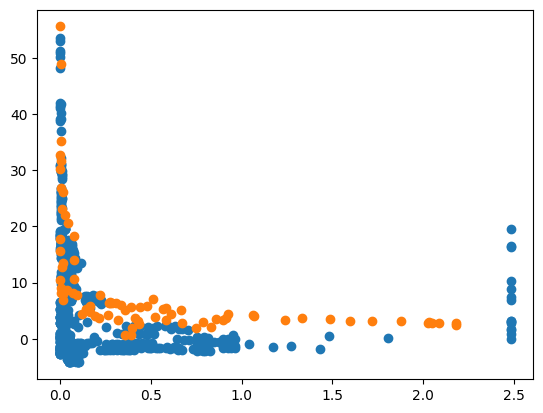

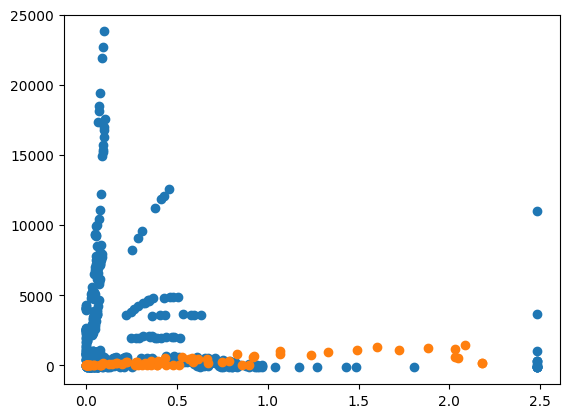

In [67]:
plt.scatter(CAp,SECp)
plt.scatter(raw_Data['CA'],raw_Data['SEC'])
plt.show()
plt.scatter(CAp,JLAp)
plt.scatter(raw_Data['CA'],raw_Data['JLA'])
plt.show()